## Data Analysis IOWA Dataset - Notebook Data_Exploration (1)

**Status:** PUBLIC Distribution <br>

**Author:** aume Manero IE<br>
**Date created:** 2021/02/1<br>
**Last modified:** 2023/04/12<br>
**Description:** Analysis of IOWA Dataset

In [1]:
# Liquor Sales : 
#    file: https://mydata.iowa.gov/Sales-Distribution/Iowa-Liquor-Sales/m3tr-qhgy
# US County Boundaries & FIP Codes
#    file: https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_county_20m.zip
# Counties Population
#    file: https://data.iowa.gov/Community-Demographics/County-Population-in-Iowa-by-Year/qtnr-zsrc
# Cities in IOWA population
#    file: https://data.iowa.gov/Community-Demographics/Total-City-Population-by-Year/acem-thbp

In [2]:
import pandas as pd
from thefuzz import fuzz
import folium
import warnings
import geopandas
import matplotlib.pyplot as plt
import matplotlib as mpl
import plotly.figure_factory as ff
import plotly.graph_objects as go
%matplotlib inline
warnings.filterwarnings('ignore')

In [3]:
file = 'Iowa_Liquor_Sales.csv'
df = pd.read_csv(file, header=0)

In [4]:
df.dtypes

Invoice/Item Number       object
Date                      object
Store Number               int64
Store Name                object
Address                   object
City                      object
Zip Code                  object
Store Location            object
County Number            float64
County                    object
Category                 float64
Category Name             object
Vendor Number            float64
Vendor Name               object
Item Number               object
Item Description          object
Pack                       int64
Bottle Volume (ml)         int64
State Bottle Cost        float64
State Bottle Retail      float64
Bottles Sold               int64
Sale (Dollars)           float64
Volume Sold (Liters)     float64
Volume Sold (Gallons)    float64
dtype: object

In [5]:
df.columns

Index(['Invoice/Item Number', 'Date', 'Store Number', 'Store Name', 'Address',
       'City', 'Zip Code', 'Store Location', 'County Number', 'County',
       'Category', 'Category Name', 'Vendor Number', 'Vendor Name',
       'Item Number', 'Item Description', 'Pack', 'Bottle Volume (ml)',
       'State Bottle Cost', 'State Bottle Retail', 'Bottles Sold',
       'Sale (Dollars)', 'Volume Sold (Liters)', 'Volume Sold (Gallons)'],
      dtype='object')

In [6]:
df[['dummy','Lat', 'Lon']]= df['Store Location'].str.split(" ", n=-1, expand=True)

In [7]:
df['Lat'] = df['Lat'].str.replace('(', '')
df['Lon'] = df['Lon'].str.replace(')', '')

In [8]:
a = df['Store Location'].unique()
print( 'There are', len(a), 'stores')

There are 2174 stores


In [9]:
# to make the problem easier for the laptops we perform the exploration in 2015
df['Date'] = pd.to_datetime(df['Date'])
df_2015 = df[df['Date'].dt.year == 2015]

In [10]:
# do we have invoices with multiple lines?
#pd.concat(g for _, g in df.groupby("Invoice/Item Number") if len(g) > 1)
#df[df.duplicated(["Invoice/Item Number"], keep=False)]

In [11]:
# Split invoice and item in two columns
df["invoice_number"] = df["Invoice/Item Number"].str[1:9]
df["item_number"]    = df["Invoice/Item Number"].str[9:12]

In [12]:
df["invoice_number"]

0           NV-18689
1           NV-18943
2           NV-18528
3           NV-18741
4           NV-18645
              ...   
22494539    NV-18815
22494540    NV-18480
22494541    NV-18563
22494542    NV-19014
22494543    NV-18522
Name: invoice_number, Length: 22494544, dtype: object

In [13]:
df.sort_values(["invoice_number", "item_number"], ascending=[True, True], inplace=True)

In [14]:
df_2015.columns

Index(['Invoice/Item Number', 'Date', 'Store Number', 'Store Name', 'Address',
       'City', 'Zip Code', 'Store Location', 'County Number', 'County',
       'Category', 'Category Name', 'Vendor Number', 'Vendor Name',
       'Item Number', 'Item Description', 'Pack', 'Bottle Volume (ml)',
       'State Bottle Cost', 'State Bottle Retail', 'Bottles Sold',
       'Sale (Dollars)', 'Volume Sold (Liters)', 'Volume Sold (Gallons)',
       'dummy', 'Lat', 'Lon'],
      dtype='object')

##### =============================================================================================================
### Ranking of vendors
##### =============================================================================================================

In [15]:
# Solve uppercase and lowercase
df['Vendor Name'] = df['Vendor Name'].str.upper()

In [16]:
df['Vendor Name'] = df['Vendor Name'].apply(str)
vendors_lst = df['Vendor Name'].unique().tolist()
vendors_lst.sort()

In [17]:
vendors_lst

['10TH MOUNTAIN WHISKEY & SPIRIT COMPANY',
 '3 BADGE CORPORATION',
 '3 BADGE MIXOLOGY',
 '3-OAKS DISTILLERY, LLC',
 '45TH PARALLEL SPIRITS',
 'A HARDY / U.S.A., LTD.',
 'A HARDY USA LTD',
 'A V BRANDS INC',
 "ADAMBA IMPORTS INT'L, INC.",
 'AHA TORO SPIRITS INC',
 'AHA TORO SPIRITS INC / AHA YETO TEQUILA',
 'AIKO IMPORTERS INC',
 'ALLEGHENY DISTILLING LLC',
 'ALTAMAR BRANDS LLC',
 'AMERICAN HERITAGE DISTILLERS, LLC',
 'AMERICAN HERITAGE DISTILLERS, LLC / CENTURY FARMS DISTILLERY',
 'AMERICAN SPIRITS EXCHANGE',
 'AMERICAN VINTAGE BEVERAGE',
 'ANCHOR DISTILLING',
 'ANCHOR DISTILLING (PREISS IMPORTS)',
 'ANHEUSER-BUSCH/LONGTAIL LIBATIONS',
 'ARTISAN GRAIN DISTILLERY',
 'ASDSPIRITS, LLC',
 'AVENIU BRANDS',
 'B. T. O. DISTILLERS LLC',
 'BACARDI U.S.A., INC.',
 'BACARDI USA INC',
 'BACMAR INTERNATIONAL',
 'BAD BEAR ENTERPRISES',
 'BAD BEAR ENTERPRISES LLC',
 'BAD BEAR ENTERPRISES LLC / LEGENDARY RYE',
 'BARON NAHMIAS INC',
 'BARREL HOUSE DISTILLING CO.',
 'BE IN GOOD SPIRITS LLC / FRANKLY ORG

##### =============================================================================================================
### How to homogeneize a dataframe column eliminating duplicates and synonyms with fuzzy comparison
##### =============================================================================================================

In [18]:
# We test several similarity measures. We use a combination of levenstein distance calculation

In [19]:
#see https://github.com/seatgeek/thefuzz
def similar(e1,e2):
    k1 = fuzz.ratio(e1,e2)
    k2 = fuzz.partial_ratio(e1,e2)
    k3 = fuzz.token_sort_ratio(e1,e2)
    k4 = fuzz.partial_token_sort_ratio(e1,e2)
    k5 = fuzz.token_set_ratio(e1,e2)
    k = (k1+k2+k3+k4+k5)/5
#    print(k,k1,k2,k3,k4)
    if k >= 80:          # if are similar
       return True
    else:
        return False


In [20]:
from Levenshtein import distance as levenshtein_distance
from Levenshtein import ratio
from Levenshtein import hamming
from Levenshtein import jaro
from Levenshtein import jaro_winkler

def similar1(e1,e2):
    return levenshtein_distance(e1,e2)
def similar2(e1,e2):
    return ratio(e1,e2)
def similar3(e1,e2):
    if len(e1) < len (e2):
        e2 = e2[0:len(e1)]
    else:
        e1 = eq[0:len(e2)]
    return hamming(e1,e2)
def similar4(e1,e2):
    return jaro(e1,e2)
def similar5(e1,e2):
    return int(jaro_winkler(e1,e2)*100)

In [21]:
print(similar1('LEVECKE CORP','LEVECKE CORPORATION'))
print(similar2('LEVECKE CORP','LEVECKE CORPORATION'))
print(similar3('LEVECKE CORP','LEVECKE CORPORATION'))
print(similar4('LEVECKE CORP','LEVECKE CORPORATION'))
print(similar5('LEVECKE CORP','LEVECKE CORPORATION'))
print(similar3('S&B FARMS DISTILLERY','S&B FARMSTEAD DISTILLERY'))
print(similar4('S&B FARMS DISTILLERY','S&B FARMSTEAD DISTILLERY'))
print(similar5('S&B FARMS DISTILLERY','S&B FARMSTEAD DISTILLERY'))
print(similar5('LUXCO INC', 'LUXCO-CLEVELAND'))
print(similar5('SAZERAC CO., INC.',  'SAZERAC COMPANY  INC'))

7
0.7741935483870968
0
0.8771929824561404
92
11
0.8777777777777779
92
82
89


In [22]:
print(similar('LEVECKE CORP','LEVECKE CORPORATION'))
print(similar('S&B FARMS DISTILLERY','S&B FARMSTEAD DISTILLERY'))
print(similar('DUNKEL CORPORATION','DUNKEL CORPORATION / IOWA DISTILLING'))
print(similar('3 BADGE CORPORATION', 'DUNKEL CORPORATION'))
print(similar('BOOT HILL DISTILLERY LLC','BULL RUN DISTILLERY LLC'))
print(similar('KINDRED SPIRIT N AMERICA', 'KINDRED SPIRITS OF NORTH AMERICA'))
print(similar('3 BADGE CORPORATION', '3 BADGE MIXOLOGY'))
print(similar('B. T. O. DISTILLERS LLC', 'DISTILLERS WAY, LLC'))
print(similar('A HARDY / U.S.A., LTD.', 'A HARDY USA LTD'))
print(similar('LUXCO INC', 'LUXCO-CLEVELAND'))
print(similar('SAZERAC CO., INC.',  'SAZERAC COMPANY  INC'))

True
True
True
False
False
True
False
True
True
False
True


In [23]:
similar('apple', 'red apple')

True

In [24]:
similar('apple', 'bananas')

False

In [25]:
    
def homogen(x):
    for e in MEGA_lst:
       if x in e:
          return e[0]
          break
    return x

mega_lst = []
for i in range(0, len(vendors_lst)):
    el = vendors_lst[i]
    hit_list = []
    for element in vendors_lst:

        if (similar(element, el)): 
            hit_list.append(element)
    hit_list.sort() 
    if (len(hit_list)) > 1:
        mega_lst.append(hit_list)

MEGA_lst = [list(tupl) for tupl in {tuple(item) for item in mega_lst}] # trick to eliminate duplicates
MEGA_lst.sort()
df['Vendor Name simple'] = df['Vendor Name'].apply(homogen)  
print('duplicate categories eliminated with Fuzzy and Levenshtein distance - see thefuzz package')

duplicate categories eliminated with Fuzzy and Levenshtein distance - see thefuzz package


In [26]:
MEGA_lst

[['A HARDY / U.S.A., LTD.', 'A HARDY USA LTD'],
 ['AHA TORO SPIRITS INC', 'AHA TORO SPIRITS INC / AHA YETO TEQUILA'],
 ['AMERICAN HERITAGE DISTILLERS, LLC',
  'AMERICAN HERITAGE DISTILLERS, LLC / CENTURY FARMS DISTILLERY'],
 ['ANCHOR DISTILLING', 'ANCHOR DISTILLING (PREISS IMPORTS)'],
 ['B. T. O. DISTILLERS LLC', 'DISTILLERS WAY, LLC'],
 ['B. T. O. DISTILLERS LLC',
  'DISTILLERS WAY, LLC',
  'WOODY CREEK DISTILLERS LLC'],
 ['BACARDI U.S.A., INC.', 'BACARDI USA INC'],
 ['BAD BEAR ENTERPRISES',
  'BAD BEAR ENTERPRISES LLC',
  'BAD BEAR ENTERPRISES LLC / LEGENDARY RYE'],
 ['BENCHMARK BEVERAGE COMPANY LLC', 'JEM BEVERAGE COMPANY'],
 ['BENCHMARK BEVERAGE COMPANY LLC',
  'JEM BEVERAGE COMPANY',
  'PHILLIPS BEVERAGE COMPANY',
  'PROST BEVERAGE COMPANY'],
 ['BENDISTILLERY', 'BROADBENT DISTILLERY', 'BROADSLAB DISTILLERY'],
 ['BENDISTILLERY', 'BROADBENT DISTILLERY', 'DEHNER DISTILLERY'],
 ['BENDISTILLERY', 'CH DISTILLERY', 'DEHNER DISTILLERY'],
 ['BLACK SEA IMPORTS, INC', 'ITSKO IMPORTS INC', 'M

In [27]:
v_lst = df['Vendor Name simple'].unique().tolist()
v_lst.sort()
print('before', len(vendors_lst), 'after', len(v_lst))
v_lst

before 506 after 367


['10TH MOUNTAIN WHISKEY & SPIRIT COMPANY',
 '3 BADGE CORPORATION',
 '3 BADGE MIXOLOGY',
 '3-OAKS DISTILLERY, LLC',
 '45TH PARALLEL SPIRITS',
 'A HARDY / U.S.A., LTD.',
 'A V BRANDS INC',
 "ADAMBA IMPORTS INT'L, INC.",
 'AHA TORO SPIRITS INC',
 'AIKO IMPORTERS INC',
 'ALLEGHENY DISTILLING LLC',
 'ALTAMAR BRANDS LLC',
 'AMERICAN HERITAGE DISTILLERS, LLC',
 'AMERICAN SPIRITS EXCHANGE',
 'AMERICAN VINTAGE BEVERAGE',
 'ANCHOR DISTILLING',
 'ANHEUSER-BUSCH/LONGTAIL LIBATIONS',
 'ARTISAN GRAIN DISTILLERY',
 'ASDSPIRITS, LLC',
 'AVENIU BRANDS',
 'B. T. O. DISTILLERS LLC',
 'BACARDI U.S.A., INC.',
 'BACMAR INTERNATIONAL',
 'BAD BEAR ENTERPRISES',
 'BARON NAHMIAS INC',
 'BARREL HOUSE DISTILLING CO.',
 'BE IN GOOD SPIRITS LLC / FRANKLY ORGANIC VODKA',
 'BEDFORD & GROVE LLC/ CHANKASKA CREEK AND RANCH WINERY',
 'BELMONT FARMS OF VA., INC',
 'BENCHMARK BEVERAGE COMPANY LLC',
 'BENDISTILLERY',
 'BEST CASE WINES LLC',
 'BETTER BRANDS BEV CO',
 'BIAGIO CRU AND ESTATE WINES, LLC',
 'BLACK DIRT DISTILLER

In [28]:
df_rank = df.groupby(['Vendor Name simple']).sum().reset_index()

In [29]:
df_rank['Vendor Name simple'].unique().tolist()
df_rank.sort_values(["Volume Sold (Liters)"], ascending=[False], inplace=True)


In [30]:
brands = df_rank['Vendor Name simple'].tolist()

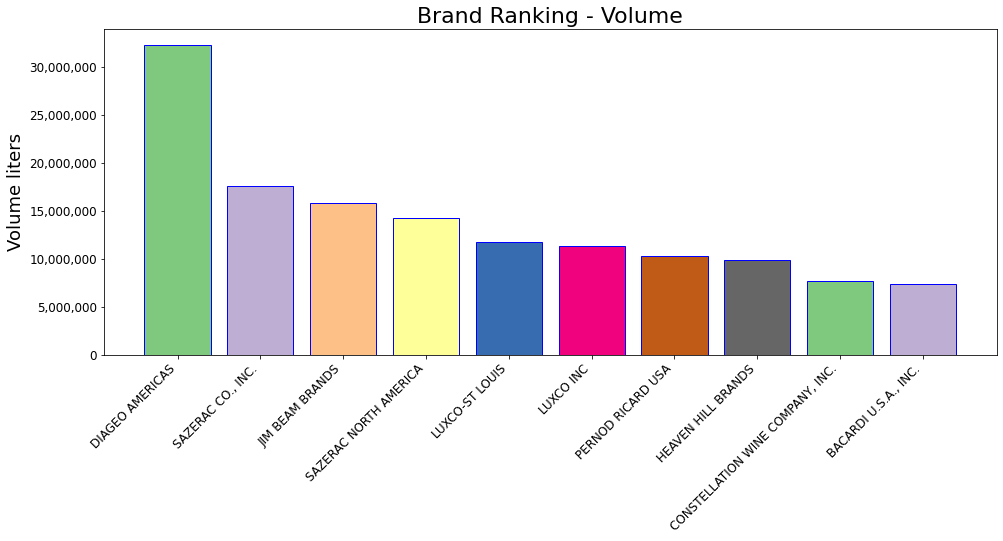

In [31]:

df_rank = df_rank.head(10)
fig, ax = plt.subplots(figsize=(16, 6))
#sns.set(style = 'white')
name = "Accent"
cmap = plt.get_cmap(name)  # type: matplotlib.colors.ListedColormap
colors = cmap.colors  # type: list

plt.title('Brand Ranking - Volume', size=22)
ax.bar(df_rank['Vendor Name simple'], df_rank['Volume Sold (Liters)'], color=colors, edgecolor='blue')
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
plt.ylabel('Volume liters', size=18)
plt.xticks(fontsize=12, rotation=45, ha='right')
plt.yticks(fontsize=12)
plt.show()

In [32]:
df_rank.columns

Index(['Vendor Name simple', 'Store Number', 'County Number', 'Category',
       'Vendor Number', 'Pack', 'Bottle Volume (ml)', 'State Bottle Cost',
       'State Bottle Retail', 'Bottles Sold', 'Sale (Dollars)',
       'Volume Sold (Liters)', 'Volume Sold (Gallons)'],
      dtype='object')

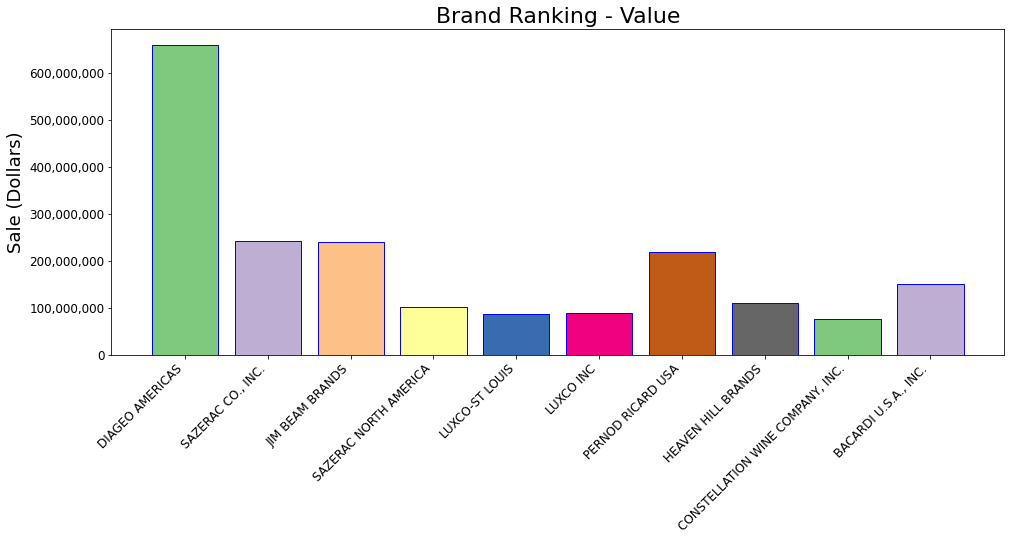

In [33]:

df_rank = df_rank.head(10)
fig, ax = plt.subplots(figsize=(16, 6))
#sns.set(style = 'white')
name = "Accent"
cmap = plt.get_cmap(name)  # type: matplotlib.colors.ListedColormap
colors = cmap.colors  # type: list

plt.title('Brand Ranking - Value', size=22)
ax.bar(df_rank['Vendor Name simple'], df_rank['Sale (Dollars)'], color=colors, edgecolor='blue')
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
plt.ylabel('Sale (Dollars)', size=18)
plt.xticks(fontsize=12, rotation=45, ha='right')
plt.yticks(fontsize=12)
plt.show()

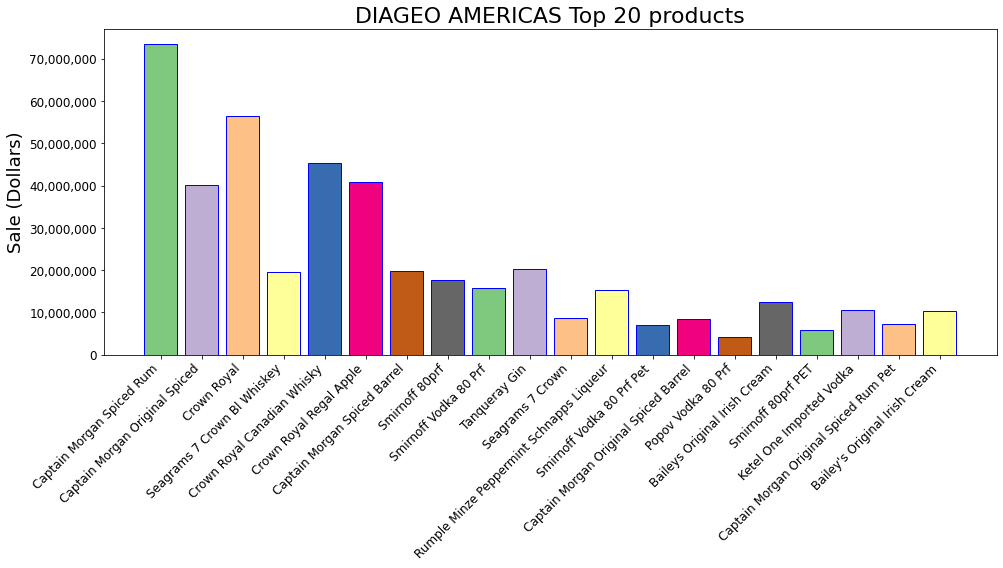

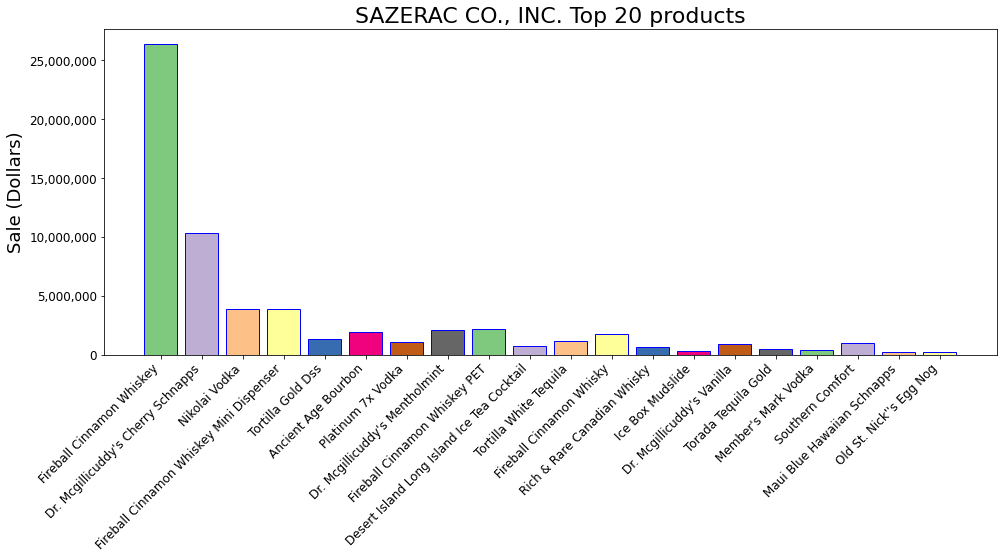

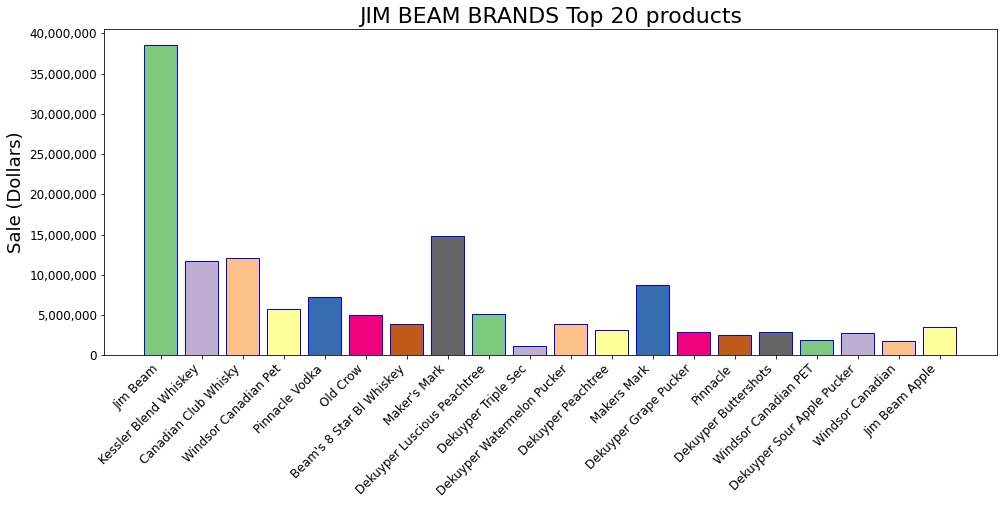

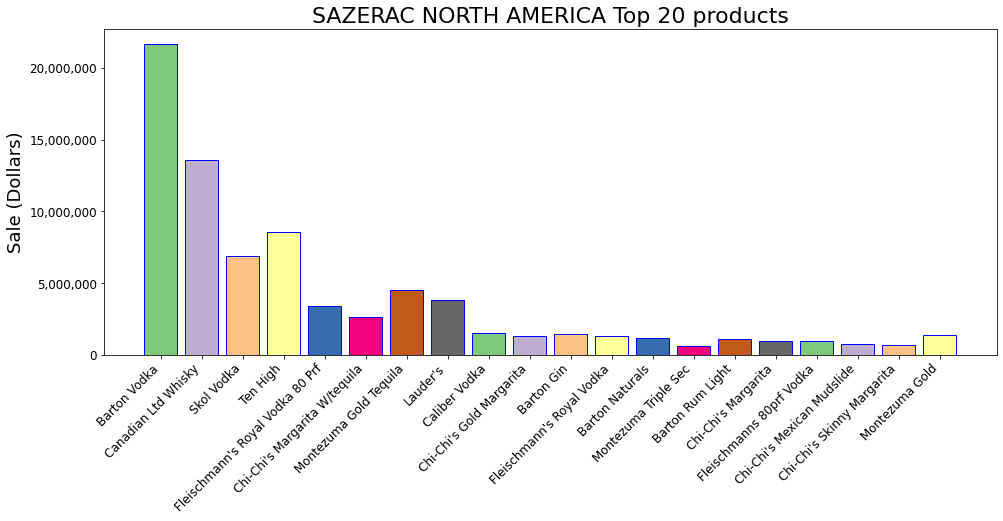

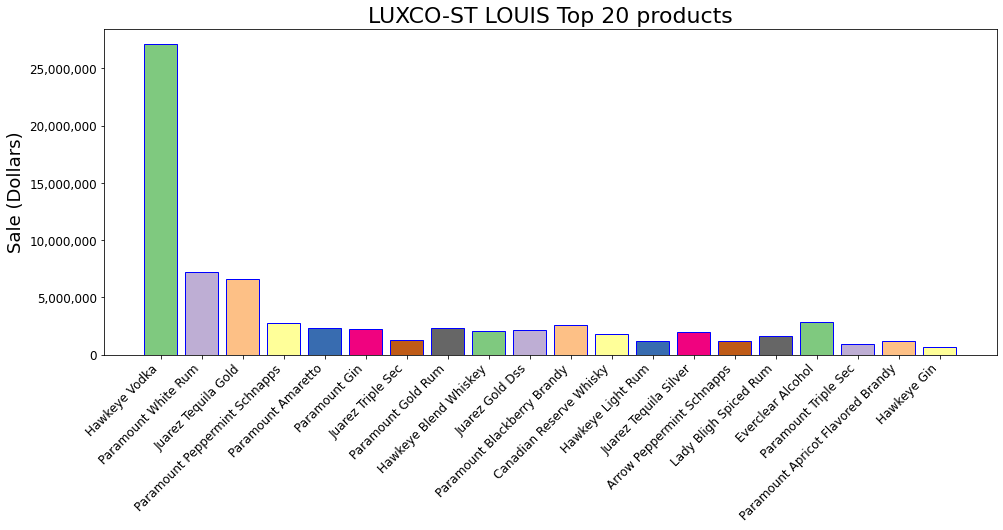

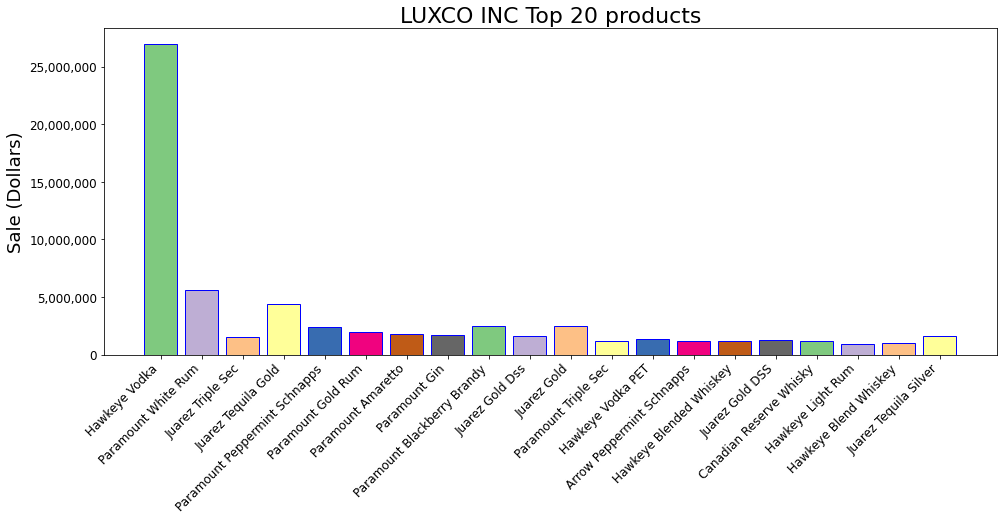

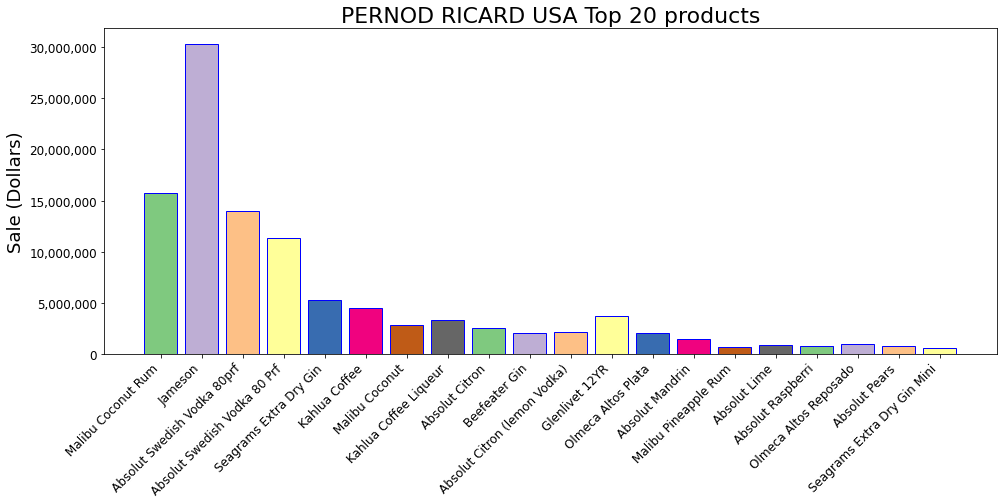

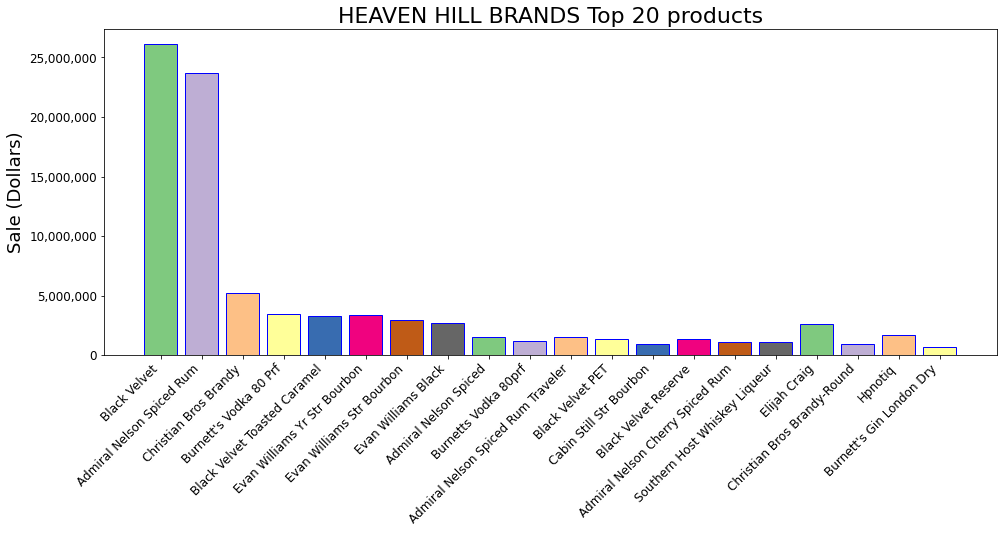

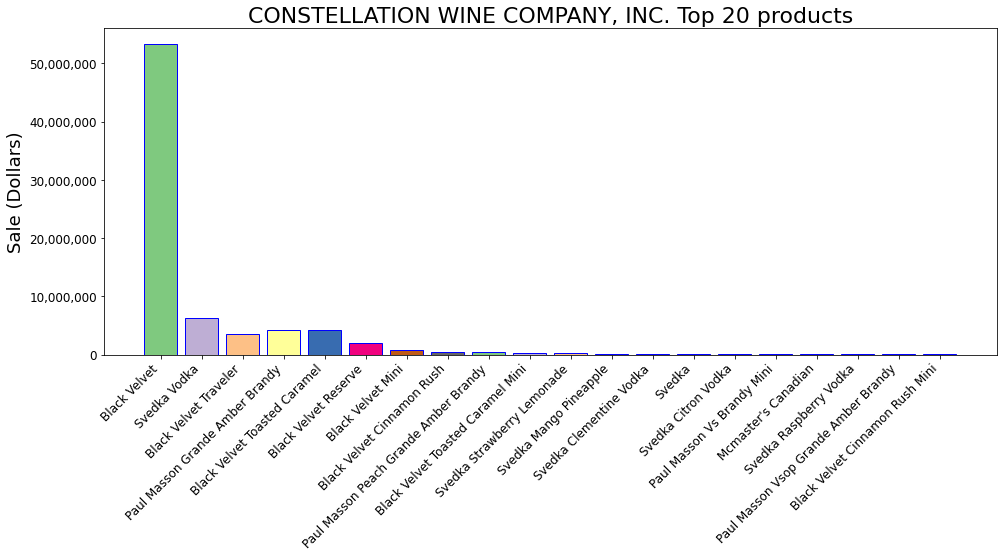

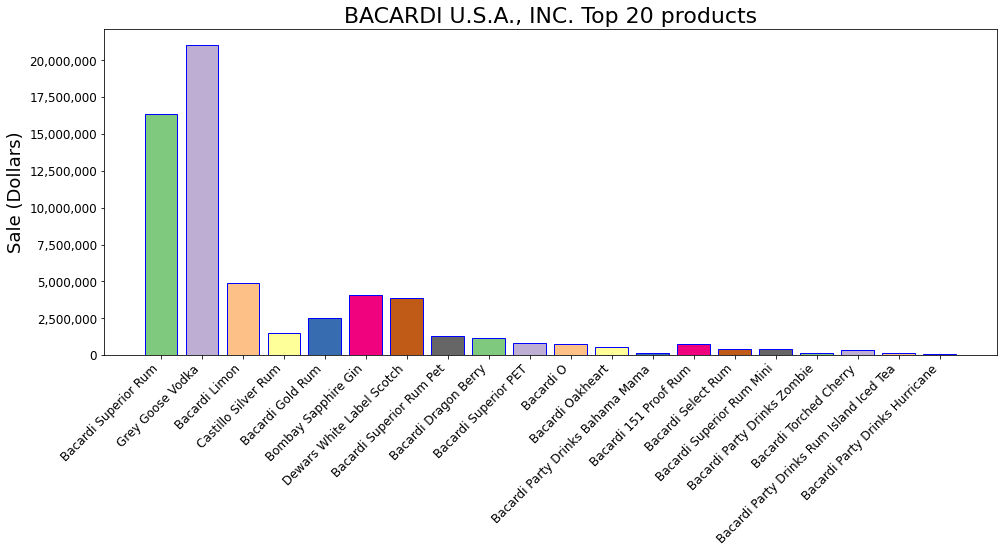

In [34]:
# Item analysis per vendor
main_brands = brands[0:10]

for br in main_brands :
   df_1 = df[df['Vendor Name'] == br]
   df_1 = df_1.groupby(['Item Description']).sum().reset_index()
   df_1.sort_values(["Volume Sold (Liters)"], ascending=[False], inplace=True)

   df_rank = df_1
   df_rank = df_rank.head(20)
   fig, ax = plt.subplots(figsize=(16, 6))
   #sns.set(style = 'white')
   name = "Accent"
   cmap = plt.get_cmap(name)  # type: matplotlib.colors.ListedColormap
   colors = cmap.colors  # type: list

   plt.title(br +' Top 20 products', size=22)
   ax.bar(df_rank['Item Description'], df_rank['Sale (Dollars)'], color=colors, edgecolor='blue')
   ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
   plt.ylabel('Sale (Dollars)', size=18)
   plt.xticks(fontsize=12, rotation=45, ha='right')
   plt.yticks(fontsize=12)
   plt.show()

In [35]:
# we obtain list of stores and location
stores_df = df.pivot_table(index=['Store Name', "Store Location", "County Number"])
cols = stores_df.columns
stores_df = stores_df.reset_index()
stores_df = stores_df.drop(cols, axis=1)

In [36]:
# Clean point format
stores_df[['dummy','Lat', 'Lon']]= stores_df['Store Location'].str.split(" ", n=-1, expand=True)
stores_df['Lat'] = stores_df['Lat'].str.replace('(', '')
stores_df['Lon'] = stores_df['Lon'].str.replace(')', '')
stores_df = stores_df.drop('dummy', axis=1)

In [37]:
stores_df

Store Name  \
0           "Double ""D"" Liquor Store"   
1            'Da Booze Barn / West Bend   
2            'Da Booze Barn / West Bend   
3     10th Hole Inn & Suite / Gift Shop   
4            16th Ave BP / Cedar Rapids   
...                                 ...   
2824                             goPuff   
2825                      goPuff / Ames   
2826                 goPuff / Iowa City   
2827             goPuff / North Liberty   
2828           k food mart / Monticello   

                             Store Location  County Number         Lat  \
0              POINT (-91.473634 43.262114)            3.0  -91.473634   
1     POINT (-73.982421 40.305231000000006)           74.0  -73.982421   
2              POINT (-94.445143 42.959247)           74.0  -94.445143   
3               POINT (-92.547769 43.36388)           45.0  -92.547769   
4              POINT (-91.667665 41.961645)           57.0  -91.667665   
...                                     ...            ...         ...   
2824           POINT (-91.534512 41.641762)           52.0  -91.534512   
2825           POINT (-93.581305 42.016041)           85.0  -93.581305   
2826           POINT (-91.534512 41.641762)           52.0  -91.534512   
2827           POINT (-91.606306 41.751471)           52.0  -91.606306   
2828           POINT (-91.185929 42.232914)           53.0  -91.185929   

                     Lon  
0              43.262114  
1     40.305231000000006  
2              42.959247  
3               43.36388  
4              41.961645  
...                  ...  
2824           41.641762  
2825           42.016041  
2826           41.641762  
2827           41.751471  
2828           42.232914  

[2829 rows x 5 columns]

In [38]:
# A simple folium visualization
# center of IOWA 93.0977 41.8780
i_size = (1,1)
#icon = folium.features.CustomIcon(icon_url,icon_size=isize)
# icons are in fontwawesome.com v4.7
from folium.plugins import BeautifyIcon

map1 = folium.Map(
    location=[41.8780,-93.0977],
    tiles='OpenStreetMap',
    zoom_start=7,
    color='red'
)

# circle marker
circle_green = BeautifyIcon(
    icon_shape='circle-dot', 
    border_color='blue', 
    border_width=3
)
#folium.Marker([-20, 25], tooltip='circle', icon=icon_circle).add_to(m)

stores_df.apply(lambda row:folium.Marker(location=[row["Lon"], row["Lat"]], popup=row['Store Name'],     
              icon=BeautifyIcon(icon_shape='circle-dot', border_color='red',
              fill_opacity=0.4)).add_to(map1), axis=1)
#             icon=folium.Icon(icon='shopping-cart', color='red', prefix='fa'), icon_size=i_size).add_to(map1), axis=1)
map1
#map1.save('test.html')
# what should we do with the 3 outliers?

In [39]:
# Let's do a map of counties 'counting' the shops in that county
# see https://georgetsilva.github.io/posts/mapping-points-with-folium/
# Loading counties geogrpahical information


In [40]:
geo_county=geopandas.read_file('cb_2018_us_county_20m.shp')
# IOWA is state n=19
geo_counties_IOWA = geo_county[geo_county['STATEFP']=='19']

In [41]:
# generate dataframe counting shops per county
# first we delete duplicates of shop names in dataframe
df_2015 = df_2015.drop_duplicates(subset=['Store Name'], keep='first', inplace=False)
# Now we count the number of stores per county << madre del cordero >>
df_2015.groupby('County')['Store Name'].count()

County
Adair          8
Adams          1
Allamakee      6
Appanoose      6
Audubon        3
              ..
Winnebago      7
Winneshiek     5
Woodbury      37
Worth          3
Wright        10
Name: Store Name, Length: 99, dtype: int64

In [42]:
counties = df_2015.groupby('County')['Store Name'].count().to_frame().reset_index()
counties

County  Store Name
0        Adair           8
1        Adams           1
2    Allamakee           6
3    Appanoose           6
4      Audubon           3
..         ...         ...
94   Winnebago           7
95  Winneshiek           5
96    Woodbury          37
97       Worth           3
98      Wright          10

[99 rows x 2 columns]

In [43]:
geo_counties_IOWA = geo_counties_IOWA.rename(columns={"NAME": "County"})
counties = counties.merge(geo_counties_IOWA, on='County')
counties = counties.rename(columns={"Store Name": "N stores"})
counties.head(3)

County  N stores STATEFP COUNTYFP  COUNTYNS        AFFGEOID  GEOID LSAD  \
0      Adair         8      19      001  00465190  0500000US19001  19001   06   
1      Adams         1      19      003  00465191  0500000US19003  19003   06   
2  Allamakee         6      19      005  00465192  0500000US19005  19005   06   

        ALAND    AWATER                                           geometry  
0  1474404193   2597996  POLYGON ((-94.70063 41.50415, -94.24159 41.503...  
1  1096686268   5367875  POLYGON ((-94.92759 41.15851, -94.70059 41.158...  
2  1655115645  51094070  POLYGON ((-91.61084 43.50069, -91.49104 43.500...

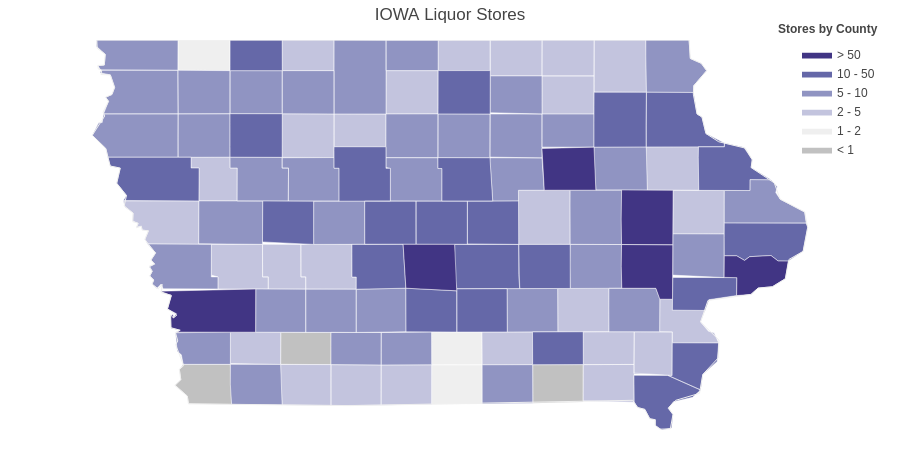

In [44]:
# Let's draw the figure
import plotly
counties['total_fip'] = counties['STATEFP']+counties['COUNTYFP']
values = counties['N stores'].tolist()
fips   = counties['total_fip'].tolist()

colorscale = [
    'rgb(193, 193, 193)',
    'rgb(239,239,239)',
    'rgb(195, 196, 222)',
    'rgb(144,148,194)',
    'rgb(101,104,168)',
    'rgb(65, 53, 132)'
]
fig = ff.create_choropleth(
    fips=fips, values=values, scope=['Iowa'],
    binning_endpoints=[1, 2, 5, 10, 50], colorscale=colorscale,
    county_outline={'color': 'rgb(255,255,255)', 'width': 0.5}, round_legend_values=True,
    legend_title='Stores by County', title='IOWA Liquor Stores'
)
fig.layout.template = None
fig.show('png')

In [45]:
# Figure of county population
file = 'County_Population_in_Iowa_by_Year.csv'
counties_population = pd.read_csv(file, header=0)

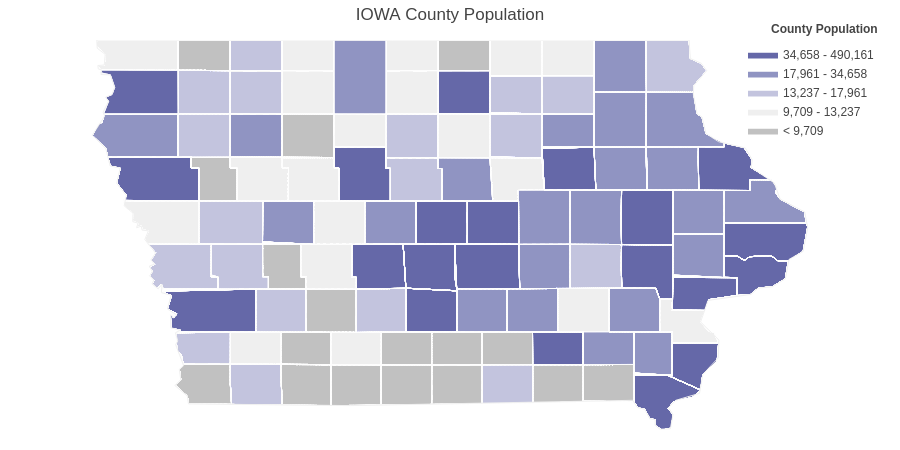

In [46]:
counties_population['Year'] = pd.to_datetime(counties_population['Year'])
cunties_population = counties_population[counties_population['Year'].dt.year == 2015]
values = counties_population['Population'].tolist()
fips   = counties_population['FIPS'].tolist()

#Calculating Binning endpoints

quartiles= counties_population['Population'].quantile([0.20,0.4,0.6,0.8,1]).values.tolist()


fig = ff.create_choropleth(
    fips=fips, values=values, scope=['Iowa'],
    binning_endpoints=quartiles, colorscale=colorscale,
    county_outline={'color': 'rgb(255,255,255)', 'width': 0.5}, round_legend_values=True,
    legend_title='County Population', title='IOWA County Population'
)
fig.layout.template = None
fig.show('png')

In [47]:
# Figure City Population IOWA
file = 'Total_City_Population_by_Year.csv'
cities_population = pd.read_csv(file, header=0)
cities_population['Year'] = pd.to_datetime(cities_population['Year'])
cities_population = cities_population[cities_population['Year'].dt.year == 2015]

In [48]:
# add lat lon cleaning POINT format
cities_population[['dummy','Lon', 'Lat']]= cities_population['Primary Point'].str.split(" ", n=-1, expand=True)
cities_population['Lon'] = cities_population['Lon'].str.replace('(', '')
cities_population['Lat'] = cities_population['Lat'].str.replace(')', '')
cities_population = cities_population.drop('dummy', axis=1)
cities_population = cities_population.sort_values(by='Population', ascending=True)

In [49]:
cities_population['text'] = cities_population['City'] + '<br>Population ' + \
                      (cities_population['Population']).astype(int).astype(str)
limits = [(0,200),(201,400),(501,600),(601,800),(801,943)]
colors = ["crimson","lightseagreen","orange","lightgrey","royalblue"]
cities = []
scale = 50

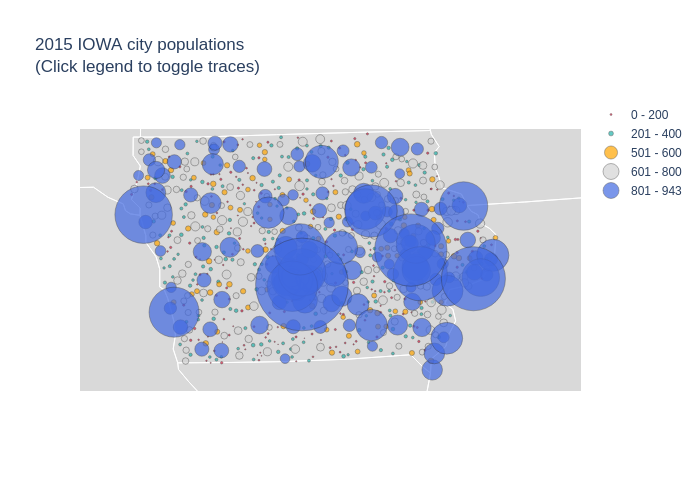

In [50]:
fig = go.Figure()


for i in range(len(limits)):
    lim = limits[i]
    df_sub = cities_population[lim[0]:lim[1]]
    fig.add_trace(go.Scattergeo(
        locationmode = 'USA-states',
        lon = df_sub['Lon'],
        lat = df_sub['Lat'],
        text = df_sub['text'],
        marker = dict(
            size = df_sub['Population']/scale,
            
            color = colors[i],
            line_color='rgb(40,40,40)',
            line_width=0.5,
            sizemode = 'area'
        ),
        name = '{0} - {1}'.format(lim[0],lim[1])))

fig.update_layout(
        title_text = '2015 IOWA city populations<br>(Click legend to toggle traces)',
        showlegend = True,
        geo = dict(
            scope = 'usa',
            landcolor = 'rgb(217, 217, 217)',
        )
    )
# focus point
lat_foc = 41.8780
lon_foc = -93.0977
fig.update_layout(
        geo = dict(
            projection_scale=8, #this is kind of like zoom
            center=dict(lat=lat_foc, lon=lon_foc), # this will center on the point
        ))
fig.show('png')# trick to freeze it in Notebook 

In [51]:
import session_info
session_info.show(html=False)

-----
Levenshtein         0.20.9
folium              0.14.0
geopandas           0.12.2
matplotlib          3.5.0
pandas              1.5.3
plotly              5.5.0
session_info        1.0.0
thefuzz             0.19.0
-----
IPython             7.29.0
jupyter_client      7.0.6
jupyter_core        4.9.1
-----
Python 3.8.12 (default, Oct 12 2021, 13:49:34) [GCC 7.5.0]
Linux-5.15.0-69-generic-x86_64-with-glibc2.17
-----
Session information updated at 2023-04-14 23:26
